## Load data and normalize by event

In [4]:
import h5py

def normalize_events(events):
    events_max = events.max(axis=1, keepdims=True)  # max per sample
    return events / events_max

def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max

with h5py.File('/home/filippo/DUNE/data/numu-CC-QE/lightweight_dataset_20cm.h5', 'r') as f:
    events = f['inputs'][:]
    truths = f['targets'][:]

X = normalize_events(events)
y = normalize_truths(truths)

## Plots to visualze data

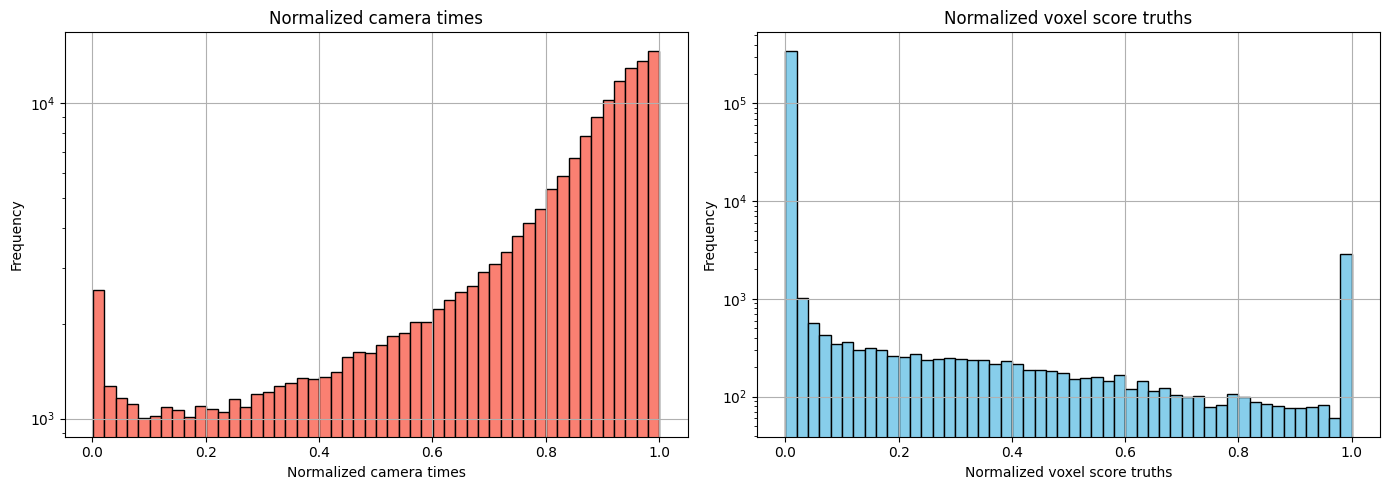

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.animation as animation

# Check normalization
plt.figure(figsize=(14, 5))

# Histogram of normalized event values (left)
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='salmon', edgecolor='black', log=True)
plt.xlabel('Normalized camera times')
plt.ylabel('Frequency')
plt.title('Normalized camera times')
plt.grid(True)

# Histogram of normalized truth values (right)
plt.subplot(1, 2, 2)
plt.hist(y.flatten(), bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Normalized voxel score truths')
plt.ylabel('Frequency')
plt.title('Normalized voxel score truths')
plt.grid(True)

plt.tight_layout()
plt.show()

# Make animation with input and expected output

n_samples = min(10, len(X))  # number of samples to animate

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)             # Left plot: Event features (line plot)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Right plot: Voxel plot

# Prepare event feature line plot
line, = ax1.plot([], [], marker='o')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, X.shape[1])
ax1.set_xlabel('Camera index')
ax1.set_ylabel('Normalized time')
ax1.grid(True)

# Prepare voxel plot color normalization and colormap
cmap = plt.get_cmap('magma')
norm = Normalize(vmin=0, vmax=1)
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(mappable, ax=ax2, shrink=0.6, pad=0.1)
cbar.set_label('Normalized score')

def update(frame):
    sample_idx = frame
    truth_sample = y[sample_idx]
    event_features = X[sample_idx]

    # Update line plot (left)
    line.set_data(np.arange(len(event_features)), event_features)
    ax1.set_title(f'Camera times - Event {sample_idx}')

    # Clear and update voxel plot (right)
    ax2.cla()
    normed = truth_sample / truth_sample.max()
    filled = normed > 0.01
    colors = cmap(norm(normed))

    ax2.voxels(filled, facecolors=colors, edgecolor='k', linewidth=0.3)

    ax2.set_xlim([0, y.shape[1]]) 
    ax2.set_ylim([0, y.shape[2]])
    ax2.set_zlim([0, y.shape[3]])

    ax2.set_xlabel('voxel_ID_x')
    ax2.set_ylabel('voxel_ID_y')
    ax2.set_zlabel('voxel_ID_z')
    ax2.set_title(f'Voxel score truth - Event {sample_idx}')

    return [line]


ani = animation.FuncAnimation(fig, update, frames=n_samples, interval=1500, blit=False)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

## Optimize model hyperparameters with Optuna

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

input_dim = len(X[0])
output_shape = y[0].shape

@register_keras_serializable()
class MaxNormalize1D(tf.keras.layers.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return inputs / (max_val + 1e-6)

# ---- Global Tracking Variables ----
best_model = None
best_history = None
best_val_loss = float("inf")
best_trial_number = None

# ---- Objective Function ----
def objective(trial):
    global best_model, best_history, best_val_loss, best_trial_number

    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(np.prod(output_shape), activation='relu'),
        MaxNormalize1D(),
        tf.keras.layers.Reshape(output_shape)
    ])

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")]
    )

    val_loss = min(history.history["val_loss"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history.history
        best_trial_number = trial.number

    return val_loss

# ---- Run Optuna Study ----

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# ---- Best Trial ----

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-09 17:39:54,103] A new study created in memory with name: no-name-e3e3cf41-5f71-44b8-9f38-a580c9b8bdb1
[I 2025-07-09 17:40:16,402] Trial 0 finished with value: 0.02551296353340149 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0014518582522220092, 'dropout_rate': 0.16074340867092812, 'batch_size': 64}. Best is trial 0 with value: 0.02551296353340149.
[I 2025-07-09 17:40:47,595] Trial 1 finished with value: 0.013440537266433239 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.009253495932060938, 'dropout_rate': 0.19785456565129966, 'batch_size': 32}. Best is trial 1 with value: 0.013440537266433239.
[I 2025-07-09 17:41:06,065] Trial 2 finished with value: 0.02231469936668873 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.00710377326313896, 'dropout_rate': 0.29774733697574607, 'batch_size': 128}. Best is trial 1 with value: 0.013440537266433239.
[I 2025-07-09 17:41:23,913] Trial 3 finished with value: 0.014804074540734291 and parameters: {'optimize

Best trial:
  Value: 0.012512053363025188
  Params:
    optimizer: rmsprop
    learning_rate: 0.0009123973600312026
    dropout_rate: 0.10290186647819055
    batch_size: 16


## Save best model

In [10]:

# Save the trained model to a file
best_model.save('/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_optuna_20cm.keras')


## Training history of best model

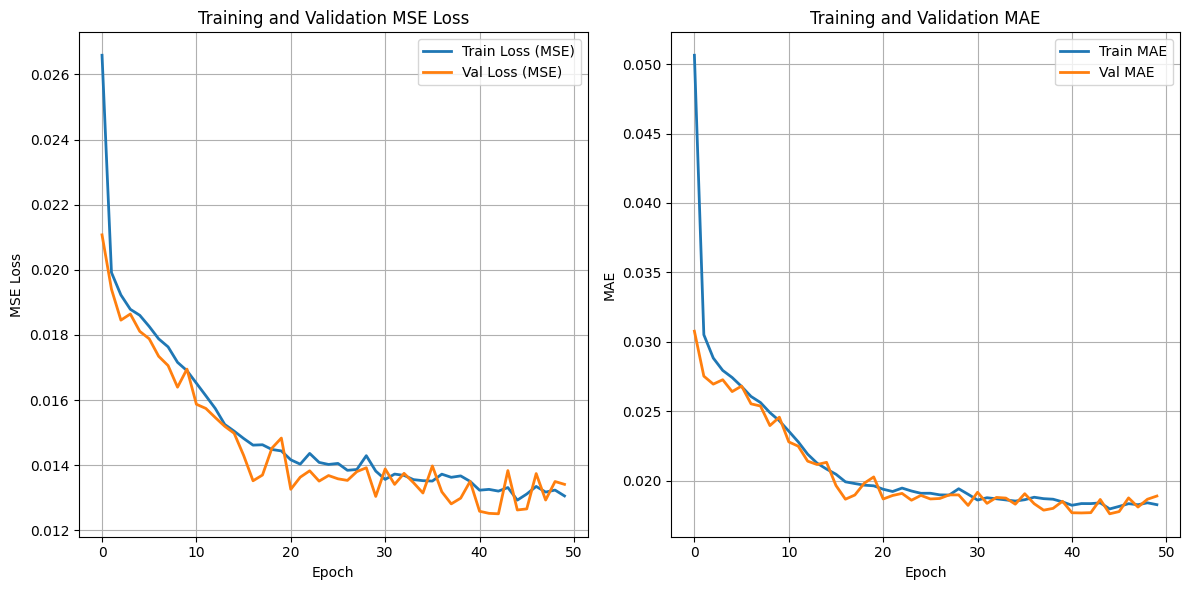

In [11]:
import matplotlib.pyplot as plt

# ---- Plot loss and MAE curves ----

plt.figure(figsize=(12, 6))

# Plot MSE Loss
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'], label='Train Loss (MSE)', lw=2)
plt.plot(best_history['val_loss'], label='Val Loss (MSE)', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(best_history['mae'], label='Train MAE', lw=2)
plt.plot(best_history['val_mae'], label='Val MAE', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Compare model predictions with truths

In [ ]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model(
    "/home/filippo/DUNE/pre-volumereco/saved_models/pre_volumereco_20cm.keras",
    custom_objects={"MaxNormalize1D": MaxNormalize1D},
    compile=True,
)

def plot_truth_vs_pred(truth, pred, sample_idx=0):
    fig, axes = plt.subplots(3, truth.shape[0], figsize=(18, 9))

    for i in range(truth.shape[0]):
        # Truth (fixed scale 0–1)
        im0 = axes[0, i].imshow(truth[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Truth - Channel {i}')
        plt.colorbar(im0, ax=axes[0, i])

        # Prediction (fixed scale 0–1)
        im1 = axes[1, i].imshow(pred[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'Prediction - Channel {i}')
        plt.colorbar(im1, ax=axes[1, i])

        # Absolute Difference (fixed scale 0–1, or tweak if needed)
        im2 = axes[2, i].imshow(np.abs(truth[i] - pred[i]), cmap='hot', aspect='auto', vmin=0, vmax=1)
        axes[2, i].set_title(f'Abs Diff - Channel {i}')
        plt.colorbar(im2, ax=axes[2, i])

    plt.suptitle(f'Truth vs Prediction with Fixed Color Scales — Sample #{sample_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get one prediction
sample_idx = 16
truth_sample = y[sample_idx]                                 
predicted = model.predict(X[sample_idx:sample_idx+1])[0]
print(X[sample_idx:sample_idx+1].shape, X[sample_idx:sample_idx+1])
plot_truth_vs_pred(y[sample_idx], predicted, sample_idx)

## Show model structure

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    #to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)


In [ ]:
from scipy.ndimage import zoom

# Original array of shape (3, 6, 7)
expected_shape = (27, 67, 69)
zoom_factors = (expected_shape[0]/predicted.shape[0],expected_shape[1]/predicted.shape[1],expected_shape[2]/predicted.shape[2])  # Non-integer factors are fine
new_array = zoom(predicted, zoom_factors, order=1)
print(new_array.shape)

plt.imshow(new_array[0], cmap='viridis', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Value')  # adds a color scale legend
plt.title('Heatmap of 2D Array')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()